In [1]:
from statsmodels.tsa.stattools import adfuller # 平稳性检测
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # 画acf, pacf图
from statsmodels.tsa.arima_model import ARIMA # ARIMA模型
from statsmodels.graphics.api import qqplot # 画qq图
from scipy.stats import shapiro # 正态检验
import statsmodels.tsa.stattools as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import warnings
import statsmodels
import seaborn as sns
import matplotlib.pylab as plt
from scipy import  stats

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

In [102]:
file1 = pd.read_csv("C:/Users/Administrator/Desktop/SWE y-e.csv")
d1 = file1[['year', 'co2']]
data1 = d1.set_index('year')
data1

,co2
year,
1834,0.033
1839,0.044
1840,0.040
1841,0.040
1842,0.081
...,...
2017,42.704
2018,42.095
2019,40.982


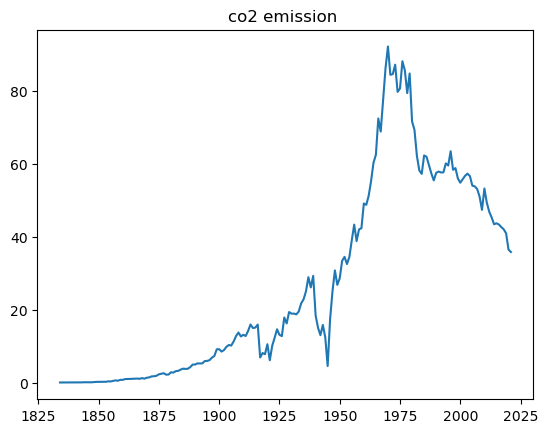

In [103]:
#切分为测试数据和训练数据
n_sample = data1.shape[0]
n_train = int(0.95 * n_sample)+1
n_forecast = n_sample - n_train
ts_train = data1.iloc[:n_train]['co2']
ts_test = data1.iloc[n_train:]['co2']

plt.plot(data1)
plt.title('co2 emission ')
plt.show()
# 可以明显看出数据不平稳


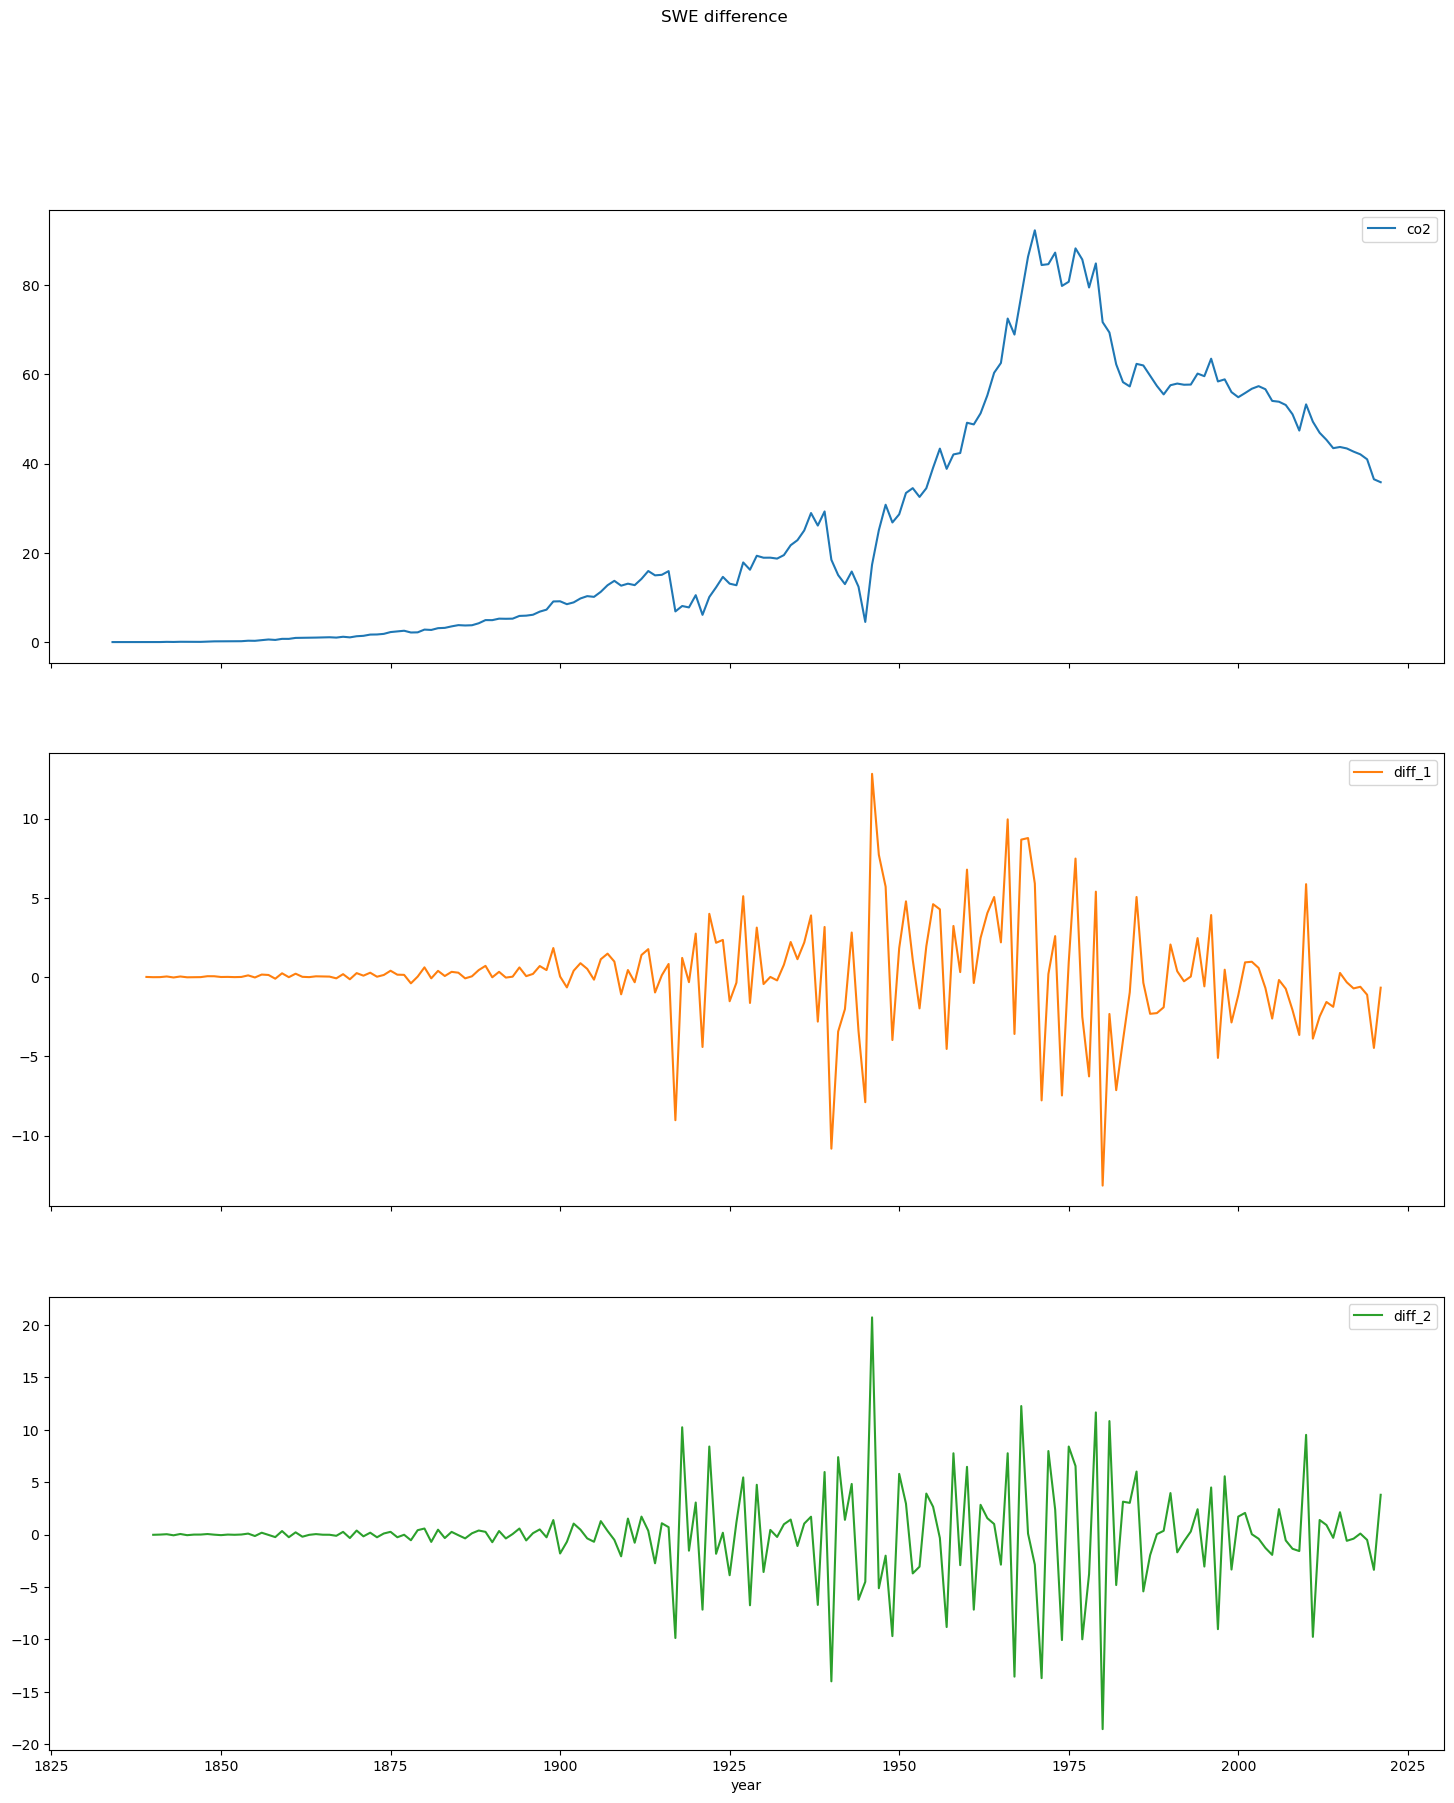

In [104]:
# 一般做一阶或二阶差分可使序列平稳
diff_df = data1.copy()
diff_df.index=data1.index
# 一阶差分
diff_df['diff_1'] =  diff_df.diff(1).dropna()
# 二阶差分
diff_df['diff_2'] = diff_df['diff_1'].diff(1).dropna()
#diff_df['diff_3'] = diff_df['diff_2'].diff(1).dropna()

# 作图
diff_df.plot(subplots=True,figsize=(18,20),title = 'SWE difference')
plt.savefig('SWE difference')
plt.show()

# 对比选择几阶差分,肉眼观察数据平稳性

In [105]:
# adfuller单位根检验数据平稳性
from statsmodels.tsa.stattools import adfuller as ADF
print(ADF(data1))  # 原始数据
print(ADF(diff_df['diff_1'].dropna()))  # 一阶差分
print(ADF(diff_df['diff_2'].dropna()))# 二阶差分

#print(ADF(diff_df['diff_3'].dropna()))

(-1.3864527510274367, 0.5887533326390434, 4, 179, {'1%': -3.4674201432469816, '5%': -2.877826051844538, '10%': -2.575452082332012}, 892.8015422292223)
(-4.842904026132475, 4.498846507507249e-05, 3, 179, {'1%': -3.4674201432469816, '5%': -2.877826051844538, '10%': -2.575452082332012}, 888.6543951027326)
(-8.675029665789245, 4.4400095357689724e-14, 7, 174, {'1%': -3.4685016947910636, '5%': -2.8782983668563396, '10%': -2.57570415906989}, 895.0483852761396)


In [108]:
ts_diff=data1.copy()
ts_diff.index=data1.index
ts_diff=data1.diff(2).dropna()

#### 可以看出原始数据不平稳，二阶平稳

In [109]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(ts_diff, lags = 20)

,lb_stat,lb_pvalue
1,51.661515,6.594274e-13
2,53.274842,2.700940e-12
3,60.716303,4.132368e-13
4,69.952038,2.323384e-14
5,70.733965,7.208774e-14
6,70.753495,2.864307e-13
7,71.357959,7.850426e-13
8,75.745068,3.498008e-13
9,83.654434,3.027645e-14
10,84.300097,7.171695e-14


#### 输出的p值远小于0.05，所以二阶差分之后的序列是平稳非白噪声序列，即数据可以用于时间序列分析，选 二阶

D:\Anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_38168\3601008671.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  pacf.show()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_38168\3601008671.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  acf.show()


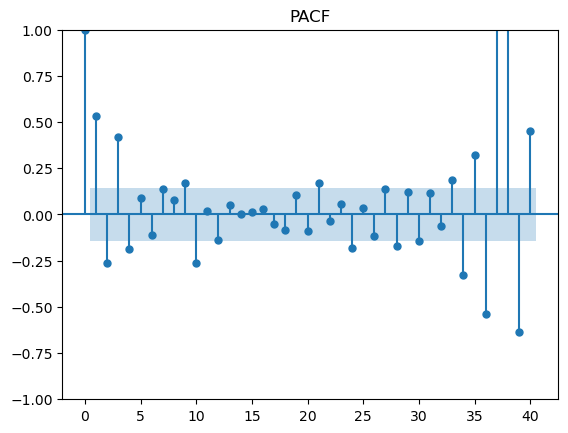

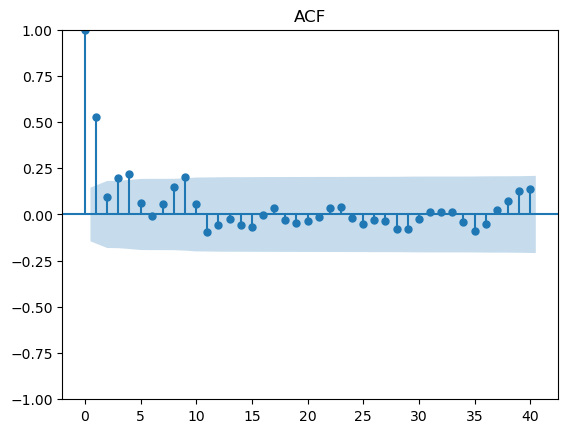

In [110]:
# 画pacf图和acf图
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
pacf = plot_pacf(ts_diff, lags=40)
plt.title('PACF')
plt.savefig('SWE’s PACF')
pacf.show()
acf = plot_acf(ts_diff, lags=40)
plt.title('ACF')
plt.savefig('SWE’s ACF')
acf.show()


In [111]:
import itertools
import numpy as np
import seaborn as sns

# 这里最大最小的参数可以自己调
p_min = 0
d_min = 0
q_min = 0
p_max = 8
d_max = 2
q_max = 8
 
# Initialize a DataFrame to store the results,，以BIC准则
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])
 
for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
 
    try:
        model = sm.tsa.ARIMA(ts_train, order=(p, d, q),
                               #enforce_stationarity=False,
                               #enforce_invertibility=False,
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue
results_bic = results_bic[results_bic.columns].astype(float)
results_bic

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda

,MA0,MA1,MA2,MA3,MA4,MA5,MA6,MA7,MA8
AR0,1035.412327,921.474368,926.105193,931.072078,935.061636,932.180800,933.428934,936.489371,941.527886
AR1,979.699797,926.062132,930.185369,935.299144,940.109862,935.482988,937.478761,941.198990,945.793215
AR2,962.943845,931.048039,935.304393,934.883030,939.899871,938.235040,942.704614,945.954206,947.540481
AR3,940.574417,935.533765,940.179768,939.213480,942.129960,940.627949,943.945551,950.551808,949.773541
AR4,944.681761,932.090480,936.999946,944.096416,940.963404,940.125732,944.390610,949.359444,954.519053
AR5,948.861959,936.895346,941.305544,945.313831,944.544807,951.948629,950.079441,954.278162,959.319732
AR6,951.599501,941.716135,945.412504,947.487675,945.729283,956.272886,954.649527,959.895999,964.323485
AR7,954.462500,946.858757,950.555666,953.208346,948.943116,961.167994,964.420574,963.634175,966.773301
AR8,948.383196,952.224404,955.571275,958.320966,964.499074,958.587906,966.644189,967.444913,972.402206


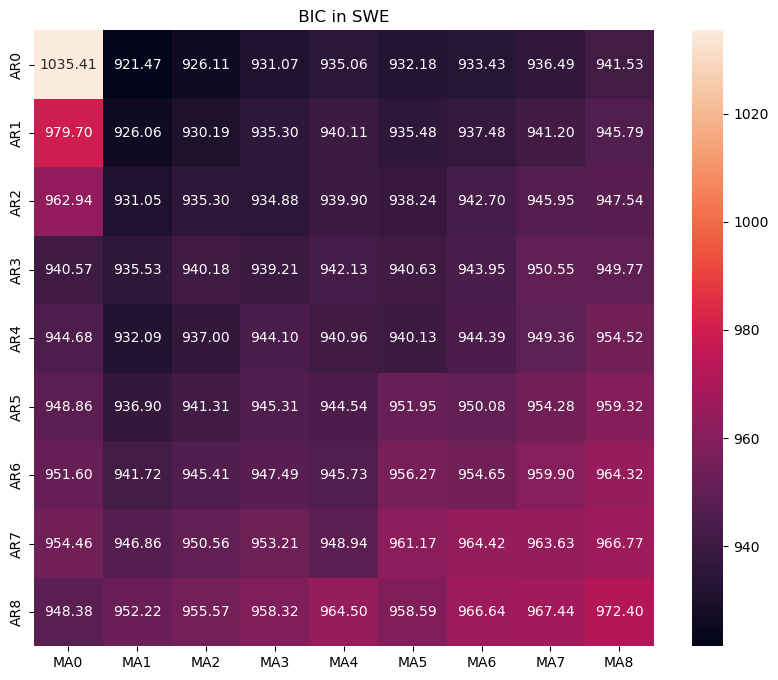

In [112]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 )
ax.set_title(' BIC in SWE ')
plt.savefig('BIC in SWE')
plt.show()

In [113]:
# 这里 max_ 数字越大运行时间越长，这里取8运行时间为 13m 13s



D:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
D:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_

AIC (3, 6)
BIC (1, 0)


D:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [114]:
from statsmodels.tsa.arima_model import ARIMA
# ARIMA(data, order=(p, d, q))
model = sm.tsa.arima.ARIMA(ts_train, order=(0,2,1))
result = model.fit()
result.summary()

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    co2   No. Observations:                  175
Model:                 ARIMA(0, 2, 1)   Log Likelihood                -455.584
Date:                Thu, 08 Jun 2023   AIC                            915.168
Time:                        22:11:46   BIC                            921.474
Sample:                             0   HQIC                           917.726
                                - 175                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9583      0.018    -54.289      0.000      -0.993      -0.924
sigma2        11.1842      0.738     15.150      0.000       9.737      12.631
===================================================================================
Ljung-Box (L1) (Q):                   0.52   Jarque-Bera (JB):               134.95
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):             487.56   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [115]:
predict = result.predict(0,216)
predict

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


0       0.000000
1       0.049500
2       0.055000
3       0.043493
4       0.042325
         ...    
212    33.034335
213    32.668949
214    32.303563
215    31.938177
216    31.572791
Name: predicted_mean, Length: 217, dtype: float64

In [116]:
list1 = []
list2 = []
for i in range(0,len(predict)):
    a = predict[i]
    list1.append(a)
    list2.append(1834+i)
list1,list2

([0.0,
  0.04950000016026043,
  0.05500011789520527,
  0.043493348700506425,
  0.042325395894815945,
  0.09305516222733981,
  0.06417038572729722,
  0.11007121680159478,
  0.09584443902419099,
  0.08693057349846223,
  0.08624485795340049,
  0.14978912553954696,
  0.20905908052178576,
  0.21642672908454855,
  0.23039099514593386,
  0.22925685049097388,
  0.24008847405587774,
  0.3569686049817123,
  0.33212039160255724,
  0.5024925677360155,
  0.6453641833689261,
  0.5383366785855703,
  0.7930738124087878,
  0.7866698174199318,
  1.0127084985700845,
  1.0302567229696342,
  1.0279030797970143,
  1.0793772779402069,
  1.1234603274919437,
  1.1559842384740455,
  1.0730881378588908,
  1.2674611610902324,
  1.122806578175293,
  1.386204222614737,
  1.4804099054840658,
  1.7691698550094683,
  1.7936825171320532,
  1.932272880495822,
  2.3508629640544623,
  2.508391979444246,
  2.654246011190855,
  2.24109487302031,
  2.272848769802166,
  2.913390940996407,
  2.8293021437624386,
  3.23819675677

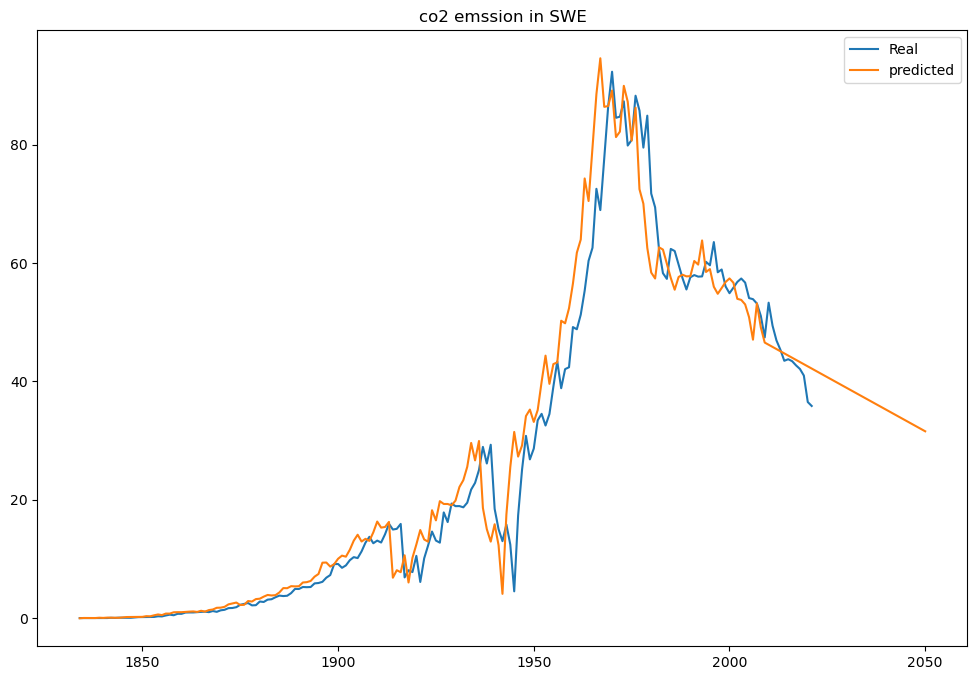

In [117]:
plt.figure(figsize=(12, 8))
plt.title('co2 emssion in SWE')
plt.plot(data1,label='Real')
plt.plot(list2,list1,label='predicted')
plt.legend()
plt.savefig('co2 emssion in SWE')
plt.show()


#### AIC

In [118]:
from statsmodels.tsa.arima_model import ARIMA
# ARIMA(data, order=(p, d, q))
model = sm.tsa.arima.ARIMA(ts_train, order=(6,2,3))
result = model.fit()
result.summary()

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-inverti

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    co2   No. Observations:                  175
Model:                 ARIMA(6, 2, 3)   Log Likelihood                -447.977
Date:                Thu, 08 Jun 2023   AIC                            915.955
Time:                        22:12:10   BIC                            947.488
Sample:                             0   HQIC                           928.747
                                - 175                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.5290      0.083    -18.484      0.000      -1.691      -1.367
ar.L2         -0.9372      0.131     -7.143      0.000      -1.194      -0.680
ar.L3          0.1222      0.117      1.041      0.298      -0.108       0.352
ar.L4          0.3793      0.146      2.601      0.009       0.093       0.665
ar.L5          0.3836      0.148      2.592      0.010       0.094       0.674
ar.L6          0.1726      0.083      2.079      0.038       0.010       0.335
ma.L1          0.5345    113.104      0.005      0.996    -221.145     222.214
ma.L2         -0.5370    173.631     -0.003      0.998    -340.848     339.774
ma.L3         -0.9975    112.979     -0.009      0.993    -222.432     220.437
sigma2         9.9283   1124.534      0.009      0.993   -2194.117    2213.974
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               186.77
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             431.79   Skew:                            -0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [119]:
predict = result.predict(0,216)
predict

D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


0       0.000000
1       0.049500
2       0.055000
3       0.044130
4       0.042331
         ...    
212    55.555991
213    55.783556
214    56.188102
215    56.260846
216    56.668107
Name: predicted_mean, Length: 217, dtype: float64

In [120]:
list3 = []
list4 = []
for i in range(0,len(predict)):
    a = predict[i]
    list3.append(a)
    list4.append(1834+i)
list3,list4

([0.0,
  0.049499984459861396,
  0.05500014511579832,
  0.044129967474514455,
  0.04233073656999521,
  0.08969220402686498,
  0.06516293172901605,
  0.10733065907833202,
  0.10488173161122549,
  0.0806038118799828,
  0.09344212177448888,
  0.14280799212536044,
  0.20214870377496547,
  0.22413872833361193,
  0.23973813543394273,
  0.23877701319468725,
  0.2376651337160435,
  0.3497150538208711,
  0.337159872301578,
  0.4955702025457456,
  0.668292086996605,
  0.5402062915614156,
  0.8140732527409018,
  0.8174922372941981,
  0.9652731615563179,
  1.1018909256267564,
  1.0109779432848836,
  1.103297094318082,
  1.1358051052317786,
  1.1065821098786641,
  1.1095245803139646,
  1.2398889489942475,
  1.1129658289353594,
  1.3791192064504256,
  1.4815845031987038,
  1.7449684802857703,
  1.8530197764181324,
  1.9290005173077969,
  2.396150705736597,
  2.4989390194883327,
  2.669378859942445,
  2.3536264960696043,
  2.2262647251073835,
  2.8978702963844514,
  2.7389424206348805,
  3.2146995421

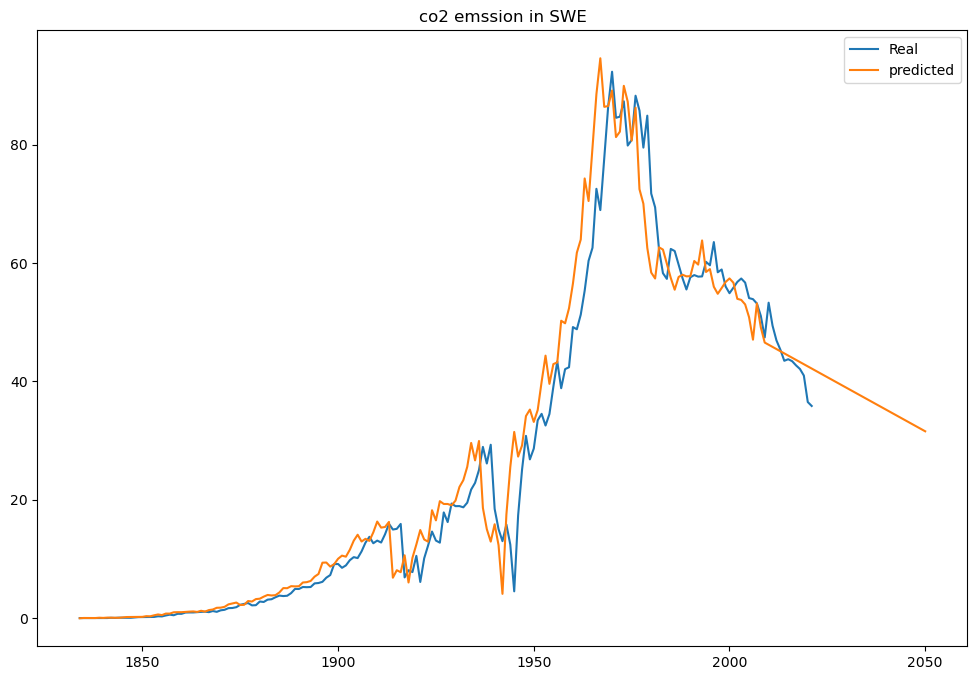

In [121]:
plt.figure(figsize=(12, 8))
plt.title('co2 emssion in SWE')
plt.plot(data1,label='Real')
plt.plot(list2,list1,label='predicted')
plt.legend()
plt.show()
